In [1]:
import confirm.outlaw.nb_util as nb_util

nb_util.setup_nb()

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax
import scipy.spatial
import pickle

jax.config.update("jax_platform_name", "cpu")
import confirm.mini_imprint.lewis_drivers as lts
import adastate
import diagnostics

In [2]:
from confirm.lewislib import lewis, batch

name = "play"
params = {
    "n_arms": 3,
    "n_stage_1": 50,
    "n_stage_2": 100,
    "n_stage_1_interims": 2,
    "n_stage_1_add_per_interim": 100,
    "n_stage_2_add_per_interim": 100,
    "stage_1_futility_threshold": 0.15,
    "stage_1_efficacy_threshold": 0.7,
    "stage_2_futility_threshold": 0.2,
    "stage_2_efficacy_threshold": 0.95,
    "inter_stage_futility_threshold": 0.6,
    "posterior_difference_threshold": 0,
    "rejection_threshold": 0.05,
    "key": jax.random.PRNGKey(0),
    "n_table_pts": 20,
    "n_pr_sims": 100,
    "n_sig2_sims": 20,
    "batch_size": int(2**12),
    "cache_tables": f"./{name}/lei_cache.pkl",
}
lei_obj = lewis.Lewis45(**params)
data, II, fp = adastate.load(name, "latest")

loading checkpoint play/173.pkl


In [3]:
P = adastate.AdaParams(
    init_K=2**11,
    n_K_double=8,
    alpha_target=0.025,
    grid_target=0.002,
    bias_target=0.002,
    nB_global=50,
    nB_tile=50,
    step_size=2**14,
    tuning_min_idx=20,
)
D = adastate.init_data(P, lei_obj, 0)

In [4]:
g, sim_sizes, bootstrap_cvs, _, _, alpha0 = data

In [5]:
worst_tile_idx = np.argmin(bootstrap_cvs[:, 0])
worst_tile = g.theta_tiles[worst_tile_idx]

In [29]:
plot_dims = [1, 2]
slc = diagnostics.build_2d_slice(g, worst_tile, plot_dims)
slc_ravel = slc.reshape((-1, g.d))
nx, ny, _ = slc.shape
tb = diagnostics.eval_bound(lei_obj, g, sim_sizes, D, slc_ravel)
tb = tb.reshape((nx, ny))

simulation runtime 9.40575623512268
simulation runtime 1.826462984085083


In [95]:
# step 1: evaluate the field of interest. if it's lambda*, we already have what
# we need. if it's TIE, we need to calculate it for the relevant tiles.

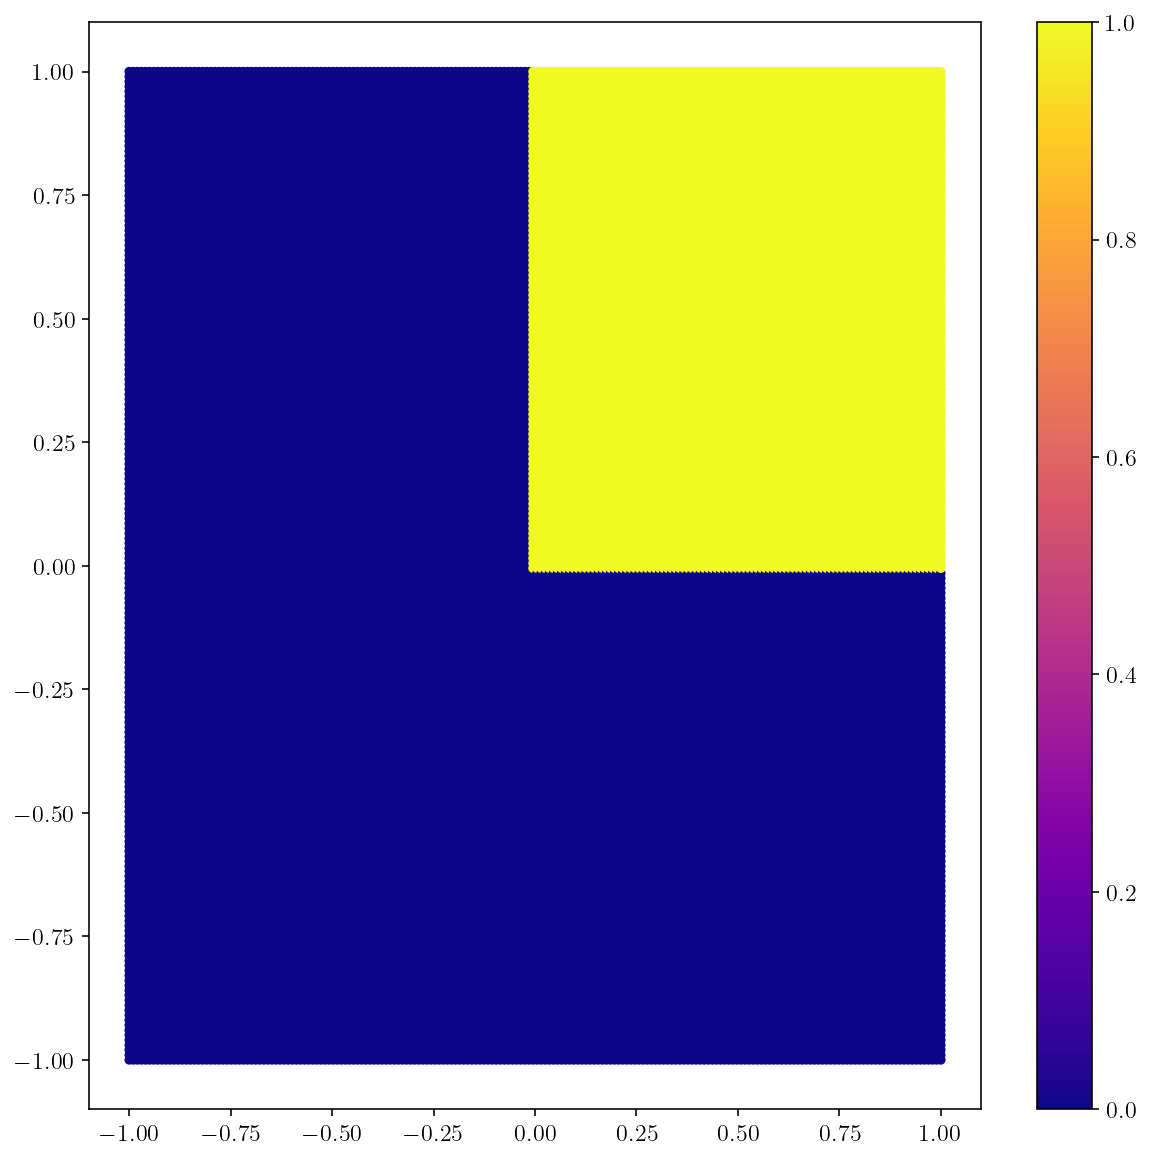

In [32]:
alt = np.logical_and(*[slc.dot(H.n) - H.c < 0 for H in g.null_hypos])
plt.figure(figsize=(10, 10))
plt.scatter(slc_ravel[:, plot_dims[0]], slc_ravel[:, plot_dims[1]], c=alt, s=14)
plt.colorbar()
plt.show()

In [98]:
alt_space = (slc[..., 1] > slc[..., 0]) & (slc[..., 2] > slc[..., 0])
sym = slc[..., 2] > slc[..., 1]


def alt_and_sym(f):
    f[alt_space] = np.nan
    f2d = f.reshape((nx, ny))
    f2d[sym] = f2d.T[sym]

In [99]:
lamstar = bootstrap_cvs[idx, 0]
alt_and_sym(lamstar)
alt_and_sym(tb)

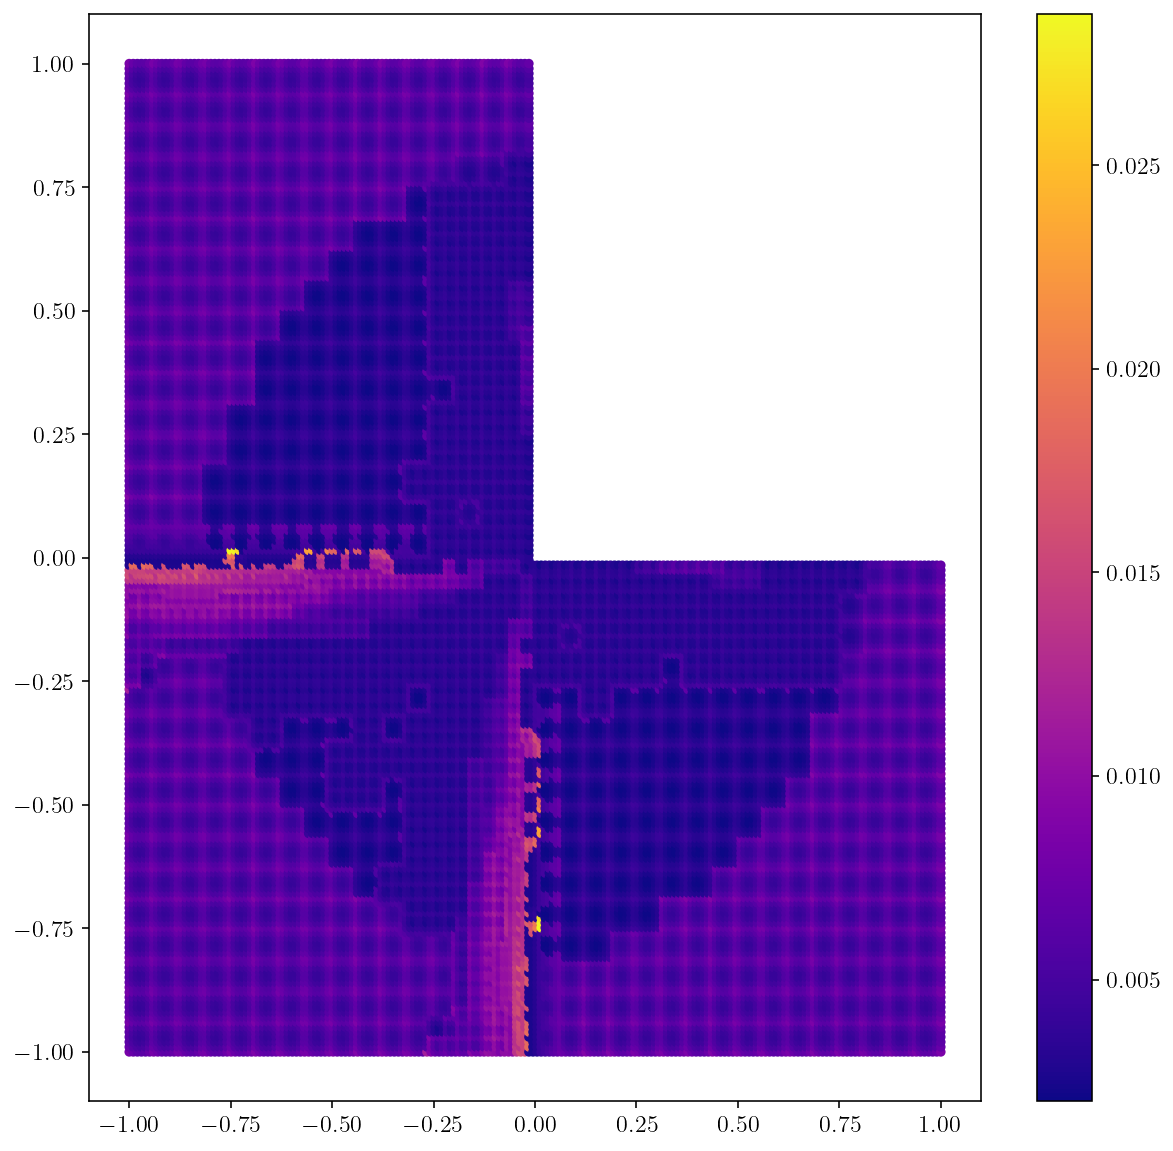

In [100]:
plt.figure(figsize=(10, 10))
plt.scatter(full_grid[:, plot_dims[0]], full_grid[:, plot_dims[1]], c=tb, s=14)
plt.colorbar()
plt.show()

/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_42087/1795720621.py:12: UserWarning: No contour levels were found within the data range.
  plt.contour(


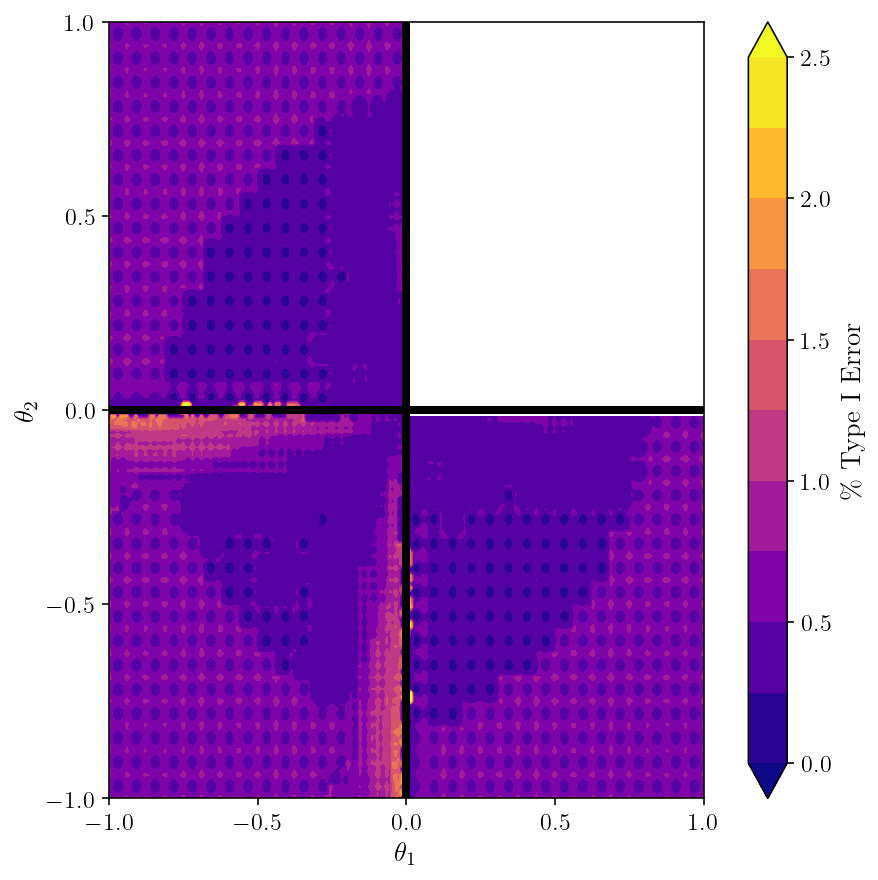

In [130]:
x = full_grid[:, plot_dims[0]].reshape((nx, ny))
y = full_grid[:, plot_dims[1]].reshape((nx, ny))
z = lamstar.reshape((nx, ny))
levels = np.linspace(0, 0.2, 11)

z = tb.reshape((nx, ny)) * 100
levels = np.linspace(0, 2.5, 11)

cmap = None
plt.figure(figsize=(6, 6), constrained_layout=True)
cbar_target = plt.contourf(x, y, z, levels=levels, extend="both", cmap=cmap)
plt.contour(
    x,
    y,
    z * 100,
    levels=levels,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    extend="both",
)
cbar = plt.colorbar(cbar_target)
cbar.set_label("\% Type I Error")
plt.axvline(x=0, color="k", linestyle="-", linewidth=4)
plt.axhline(y=0, color="k", linestyle="-", linewidth=4)
plt.xlabel(r"$\theta_1$")
plt.xticks(np.linspace(-1, 1, 5))
plt.ylabel(r"$\theta_2$")
plt.yticks(np.linspace(-1, 1, 5))
plt.show()

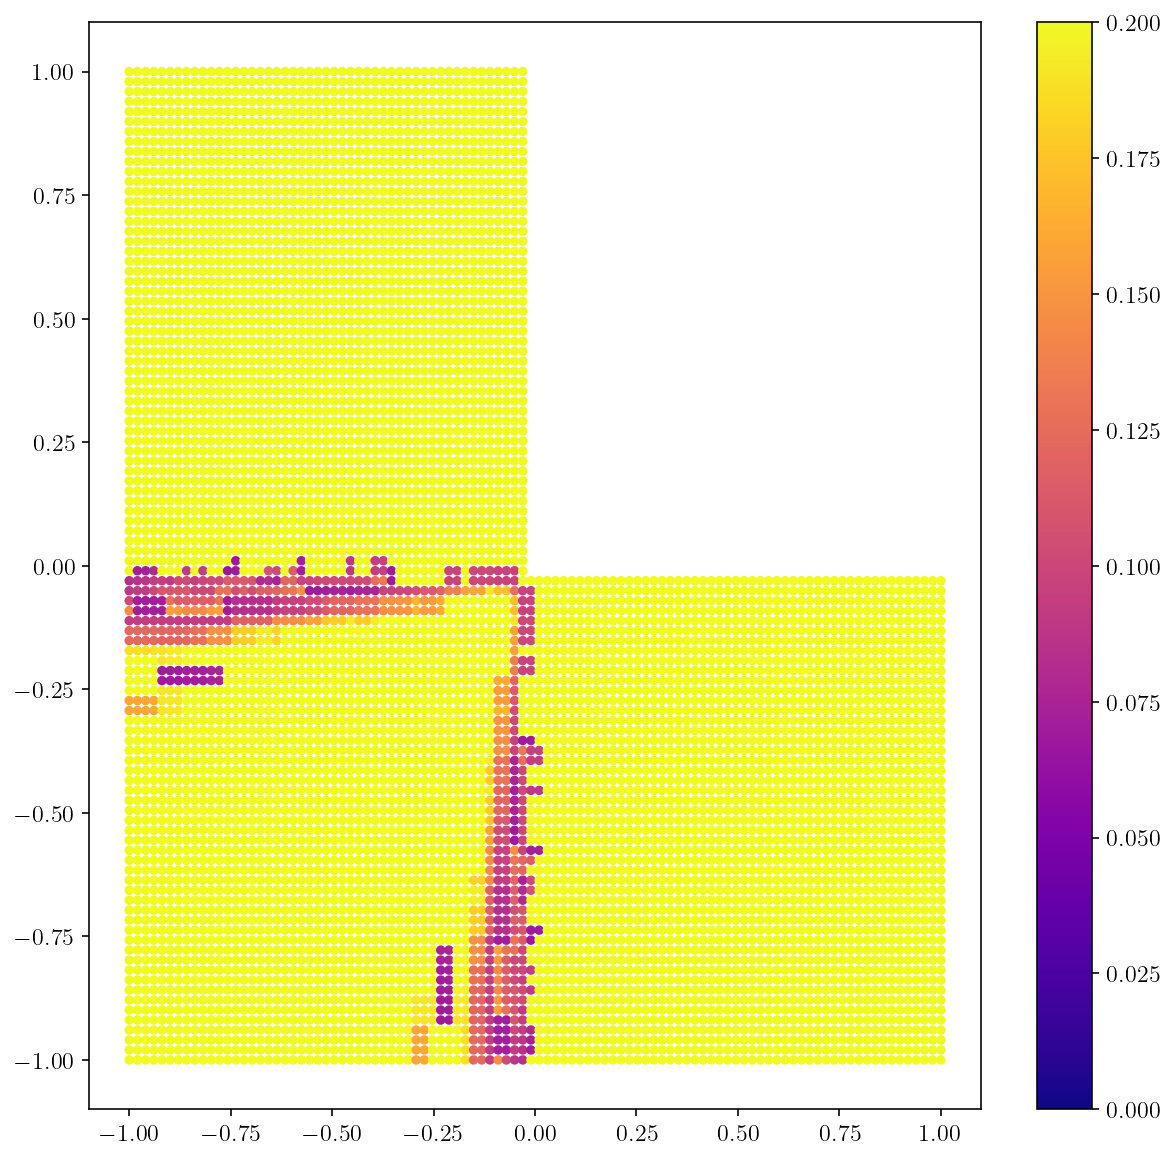

In [93]:
plt.figure(figsize=(10, 10))
plt.scatter(
    full_grid[:, plot_dims[0]],
    full_grid[:, plot_dims[1]],
    c=lamstar,
    vmin=0,
    vmax=0.2,
    s=14,
)
plt.colorbar()
plt.show()